# Applied Data Science Capstone
Zeiad Wael Sabra 4/5/2019

## Analysis of New York Airbnb Prices

![](https://raw.githubusercontent.com/OZWSO/Coursera_Capstone/master/NY/NY.PNG)


### Table of Content
1. [Introduction](#introduction)
2. [Business Plan](#business_paln)
3. [Data Selection](#data_selection)
4. [Data Exploration](#data_exploration)
5. [Next](#next)

### Introduction <a name="introduction"></a>
New York City is a huge tourist attraction visited by millions each year, making finding a place to stay a very difficult and pricey endeavour.
IsPriceRight is a website that offers recommendations for prices of Airbnb. Is the place you plan on staying at overpriced? Head to RightPrice to check if the price is right or if you are being scammed.

### Business Plan <a name=business_paln></a>

RightPrice wants us to make a model to advise tourists visiting New York City on the optimal price for a place to stay in New York city.
A tourist provides us with Information about the place and we provid him/her with the optimal price using our model.
Our goal is to build a model that give an estimate of the rent of a place in New York City using available data.  

The Desired outcomes are:   
* A model for calculating rental prices.
* A description of the most relivant features of the model.
* Cluster the Neigbourhoods based on the Rent, Venues, and location.

### Data Selection <a name=data_selection></a>
We used http://data.beta.nyc as the source of our data 

1. Geospatial Data
   * The data for the geolocations and boundries of New York's neighbourhoods was downloaded from <a href=http://data.beta.nyc//dataset/0ff93d2d-90ba-457c-9f7e-39e47bf2ac5f/resource/35dd04fb-81b3-479b-a074-a27a37888ce7/download/d085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson>here</a>
   * The data consists of Neigbourhoods names, Boroughs names, Neigbourhood bountries and some other columns.  
   
   
2. Airbnb Rental data
   * The data for the Rental Data was download from <a href= http://data.insideairbnb.com/united-states/ny/new-york-city/2015-05-01/data/listings.csv.gz>here</a>  
   * We chose the listing for may of 2015, as it is the latest data available on <a href=ttp://data.beta.nyc>data.beta.nyc</a>    
   
   
3. Foursquare API  
   * We are going to use the Foursquare API to explore the nearby venues available around each listing of the Airbnb dataset and see how they affect the price of the listing.


### Data Exploration <a name=data_exploration></a>
In this early stage we are just going to load the data, look at it and make some visualizations.

In [3]:
#importing numpy and Pandas
import pandas as pd
import numpy as np
from urllib.request import urlopen
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import matplotlib.colors as colors
import geopandas as gpd
import requests
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

Loading the geospatiol data of New York City.

In [4]:
gdf = gpd.read_file("NY/pediacitiesnycneighborhoods.geojson")
gdf.head()

neighborhood boroughCode        borough  \
0         Allerton           2          Bronx   
1  Alley Pond Park           4         Queens   
2    Arden Heights           5  Staten Island   
3        Arlington           5  Staten Island   
4         Arrochar           5  Staten Island   

                                                 @id  \
0  http://nyc.pediacities.com/Resource/Neighborho...   
1  http://nyc.pediacities.com/Resource/Neighborho...   
2  http://nyc.pediacities.com/Resource/Neighborho...   
3  http://nyc.pediacities.com/Resource/Neighborho...   
4  http://nyc.pediacities.com/Resource/Neighborho...   

                                            geometry  
0  POLYGON ((-73.84859700000018 40.87167000000012...  
1  POLYGON ((-73.74333268196389 40.7388830992604,...  
2  POLYGON ((-74.169827 40.56107800000017, -74.16...  
3  POLYGON ((-74.15974815874296 40.64141652579018...  
4  POLYGON ((-74.06077989345394 40.59318800468343...

Foursquare requires an address to search for nearby venues if we are not using the latutide and longitude coordinates. So we make an address column which is made by concatinating the neighbourhood and borough columns to avoid confusing the Foursquare API.


In [5]:
gdf['address'] = gdf["neighborhood"] + ', ' + gdf["borough"]
gdf.head()

neighborhood boroughCode        borough  \
0         Allerton           2          Bronx   
1  Alley Pond Park           4         Queens   
2    Arden Heights           5  Staten Island   
3        Arlington           5  Staten Island   
4         Arrochar           5  Staten Island   

                                                 @id  \
0  http://nyc.pediacities.com/Resource/Neighborho...   
1  http://nyc.pediacities.com/Resource/Neighborho...   
2  http://nyc.pediacities.com/Resource/Neighborho...   
3  http://nyc.pediacities.com/Resource/Neighborho...   
4  http://nyc.pediacities.com/Resource/Neighborho...   

                                            geometry  \
0  POLYGON ((-73.84859700000018 40.87167000000012...   
1  POLYGON ((-73.74333268196389 40.7388830992604,...   
2  POLYGON ((-74.169827 40.56107800000017, -74.16...   
3  POLYGON ((-74.15974815874296 40.64141652579018...   
4  POLYGON ((-74.06077989345394 40.59318800468343...   

                        address  
0               Allerton, Bronx  
1       Alley Pond Park, Queens  
2  Arden Heights, Staten Island  
3      Arlington, Staten Island  
4       Arrochar, Staten Island

Assigning  a color to each borough

In [6]:
x = {"Bronx":'red', "Manhattan":'blue', "Brooklyn":'green', "Queens":'orange', "Staten Island":'yellow'}
gdf["color"] = gdf["borough"].apply(lambda i : x[i])

Getting the latitude and longitude of New York City

In [14]:
address = 'New York, NY'
geolocator = Nominatim(user_agent="UK_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

Creating a map of the neighbourhood of New York City color coded by boroughs

In [15]:
m = folium.Map(location=[latitude, longitude], zoom_start=10, control_scale=False)
get_color = lambda x: x['properties']['color']
folium.GeoJson(gdf
            ,style_function=lambda C: {
            'fillColor': get_color(C) ,
            'color' : 'white',
            'weight' : 1,
            'fillOpacity' : 0.5},
            tooltip=folium.features.GeoJsonTooltip(
            fields=['neighborhood', 'borough'],
            aliases=['',''])).add_to(m)
m

Loading the Airbnb rental Data.

In [16]:
airbnb_rental = pd.read_csv("NY/listings.csv.gz", compression='gzip')
airbnb_rental.head()

id                           listing_url       scrape_id last_scraped  \
0  1533652  https://www.airbnb.com/rooms/1533652  20150501110800   2015-05-02   
1  3423077  https://www.airbnb.com/rooms/3423077  20150501110800   2015-05-02   
2   326908   https://www.airbnb.com/rooms/326908  20150501110800   2015-05-03   
3  4625178  https://www.airbnb.com/rooms/4625178  20150501110800   2015-05-02   
4  3614041  https://www.airbnb.com/rooms/3614041  20150501110800   2015-05-02   

                                 name  \
0      Charming Studio - Central Park   
1        Rockaway Bungalow by the Bay   
2  Cozy Mexican Inspired Private Room   
3       Modern 1BD with exposed brick   
4    Manhattan Cozy 1BR Apartment $60   

                                             summary  \
0  Stay at my charming Central Park studio apartm...   
1  Situated on a quiet block in the Rockaways our...   
2                                                NaN   
3  Newly renovated 1BD  features dark hardwood, e...   
4  Cozy apartment, top of Manhattan 225th and Bro...   

                                               space  \
0  Charming, sunny studio apartment 1/2 block fro...   
1  This is a real home lovingly re-built after Hu...   
2  Hi There,  I'm Michelle and I am excited to sh...   
3                                                NaN   
4                                                NaN   

                                         description  \
0  Stay at my charming Central Park studio apartm...   
1  Situated on a quiet block in the Rockaways our...   
2  Hi There,  I'm Michelle and I am excited to sh...   
3  Newly renovated 1BD  features dark hardwood, e...   
4  Cozy apartment, top of Manhattan 225th and Bro...   

                                         picture_url   host_id  ...  \
0  https://a1.muscache.com/ic/pictures/66278406/8...   8178950  ...   
1  https://a2.muscache.com/ic/pictures/43320896/6...  17253913  ...   
2  https://a1.muscache.com/ic/pictures/3547451/b3...   1288422  ...   
3  https://a0.muscache.com/ic/pictures/60151768/8...   8315139  ...   
4  https://a1.muscache.com/ic/pictures/45521304/2...  18210143  ...   

  review_scores_cleanliness review_scores_checkin review_scores_communication  \
0                      10.0                  10.0                        10.0   
1                       8.0                  10.0                         9.0   
2                       9.0                  10.0                        10.0   
3                      10.0                  10.0                        10.0   
4                       7.0                   7.0                         9.0   

  review_scores_location review_scores_value requires_license license  \
0                   10.0                 9.0                f     NaN   
1                    9.0                 9.0                f     NaN   
2                   10.0                 9.0                f     NaN   
3                   10.0                10.0                f     NaN   
4                    9.0                 8.0                f     NaN   

  jurisdiction_names calculated_host_listings_count reviews_per_month  
0                NaN                              1               1.1  
1                NaN                              1               1.5  
2                NaN                              1               2.4  
3                NaN                              1               0.5  
4                NaN                              1               0.2  

[5 rows x 68 columns]

List of the columns of Airbnb Rental Data

In [17]:
airbnb_rental.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_picture_url', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
       'state', 'zipcode', 'market', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet', 'price',
       'weekly_price', 'monthly_price', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'first_review', 'last_review', 'review_scores_rating',
       

There lots of listing in the airbnb data set and plotting them all would be a challenge. So, instead, we plot the firt 100 just to the data on a map.

In [18]:
for i in range(100):
    row = airbnb_rental.iloc[i, :]
    lat, long = row["latitude"], row["longitude"]
    folium.Circle(
            radius=10,
            location=[lat, long],
            popup=row["name"],
            color='black',
            fill=True
    ).add_to(m)
m

The neighbourhood names in the airbnb data is not consistant, so we have to resort to the latitude and longitude coordinates of each listing, looping over all neighbourhood and checking if the listing is in it.

In [11]:
from shapely.geometry.point import Point
def assign_neighbourhood(x):
    p = Point((x.longitude, x.latitude))
    for i, row in gdf.iterrows():
        _, _, _, _, geo, address,_ = row
        if geo.contains(p):
            return address
    return None

airbnb_rental["address"] =  airbnb_rental.apply(assign_neighbourhood, axis=1)

Convert the price column to numerical values

In [12]:
airbnb_rental["price"] = airbnb_rental["price"].map(lambda x: float(x.replace(',', '').strip()[1:]))

Saving the modified Airbnb data to avoid repeating intesive computations

In [13]:
airbnb_rental.to_csv("NY/airbnb_address.csv", index_label=False)

Filter the columns of Airbnb Data

In [86]:
airbnb_rental = pd.read_csv("NY/airbnb_address.csv")

In [20]:
cols = ["address", "name", "price", "review_scores_location", "latitude", "longitude", "bedrooms","room_type","bathrooms","property_type", "guests_included"]
airbnb_rental = airbnb_rental[cols]

In [22]:
airbnb_rental.groupby("address").count().head()

name  price  review_scores_location  latitude  \
address                                                                       
Allerton, Bronx                 11     11                      10        11   
Arden Heights, Staten Island     1      1                       0         1   
Arrochar, Staten Island          5      5                       2         5   
Arverne, Queens                  9      9                       8         9   
Astoria, Queens                448    448                     282       448   

                              longitude  bedrooms  room_type  bathrooms  \
address                                                                   
Allerton, Bronx                      11        11         11         11   
Arden Heights, Staten Island          1         1          1          1   
Arrochar, Staten Island               5         5          5          4   
Arverne, Queens                       9         9          9          8   
Astoria, Queens                     448       446        448        440   

                              property_type  guests_included  
address                                                       
Allerton, Bronx                          11               11  
Arden Heights, Staten Island              1                1  
Arrochar, Staten Island                   5                5  
Arverne, Queens                           9                9  
Astoria, Queens                         448              448

Plot a histogram of the prices to know its distribution

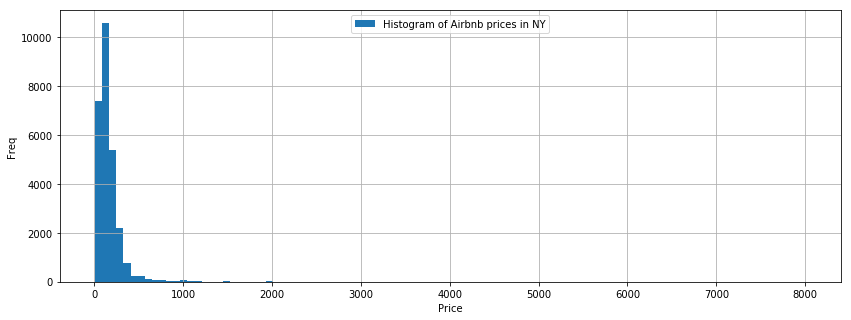

In [23]:
%matplotlib inline
plt.figure(figsize=(14,5))
hst = airbnb_rental["price"].hist(bins=100)
plt.xlabel('Price')
plt.ylabel('Freq')
plt.legend(["Histogram of Airbnb prices in NY"], loc=9)

In [24]:
airbnb_rental.price.min()

10.0

In [25]:
airbnb_rental.head()

address                                name  price  \
0  Central Park, Manhattan      Charming Studio - Central Park  150.0   
1                      NaN        Rockaway Bungalow by the Bay   60.0   
2  Central Park, Manhattan  Cozy Mexican Inspired Private Room   97.0   
3  Prospect Park, Brooklyn       Modern 1BD with exposed brick  100.0   
4                      NaN    Manhattan Cozy 1BR Apartment $60   60.0   

   review_scores_location   latitude  longitude  bedrooms        room_type  \
0                    10.0  40.781561 -73.971238       0.0  Entire home/apt   
1                     9.0  40.591061 -73.814242       1.0     Private room   
2                    10.0  40.779410 -73.969830       1.0     Private room   
3                    10.0  40.655026 -73.962212       1.0  Entire home/apt   
4                     9.0  40.873336 -73.911239       1.0  Entire home/apt   

   bathrooms property_type  guests_included  
0        1.0     Apartment                1  
1        1.0     Apartment                1  
2        1.0     Apartment                1  
3        1.0     Apartment                1  
4        1.0     Apartment                2

The minimum is 10 dollars a night, That seems a bit low. and looking at Airbnb there does not seem to be any with 10$ a night listing.

In [26]:
airbnb_rental.price.max()

8000.0

Looking at the data, we can see some prices that seem unreasonanle which will affect the behavior of anymodel, so we remove them.

In [27]:
airbnb_rental = airbnb_rental[(airbnb_rental.price< 2000) & (airbnb_rental.price > 20)]

Grouping the Airbnb data by neighbourhoods to Analyze the neigbourhoods and cluster them

In [28]:
gp_airbnb = airbnb_rental.groupby("address").mean()
gp_airbnb.head()

price  review_scores_location   latitude  \
address                                                                       
Allerton, Bronx                55.000000                8.400000  40.865331   
Arden Heights, Staten Island   60.000000                     NaN  40.562901   
Arrochar, Staten Island       420.000000                8.000000  40.592432   
Arverne, Queens               109.000000                8.625000  40.593163   
Astoria, Queens               102.600446                9.368794  40.764266   

                              longitude  bedrooms  bathrooms  guests_included  
address                                                                        
Allerton, Bronx              -73.860007  1.000000   1.090909         2.181818  
Arden Heights, Staten Island -74.185634  1.000000   0.500000         1.000000  
Arrochar, Staten Island      -74.067415  3.200000   2.500000         5.200000  
Arverne, Queens              -73.793740  1.222222   1.000000         2.000000  
Astoria, Queens              -73.920821  1.073991   1.026136         1.437500

In [29]:
gp_airbnb.reset_index(inplace=True)

In [30]:
gp_airbnb.head()

address       price  review_scores_location  \
0               Allerton, Bronx   55.000000                8.400000   
1  Arden Heights, Staten Island   60.000000                     NaN   
2       Arrochar, Staten Island  420.000000                8.000000   
3               Arverne, Queens  109.000000                8.625000   
4               Astoria, Queens  102.600446                9.368794   

    latitude  longitude  bedrooms  bathrooms  guests_included  
0  40.865331 -73.860007  1.000000   1.090909         2.181818  
1  40.562901 -74.185634  1.000000   0.500000         1.000000  
2  40.592432 -74.067415  3.200000   2.500000         5.200000  
3  40.593163 -73.793740  1.222222   1.000000         2.000000  
4  40.764266 -73.920821  1.073991   1.026136         1.437500

Viusalizing the average rating for each neigbourhood according to the airbnb dataset.

Dark regions have no data.

In [31]:
m = folium.Map(location=[latitude, longitude], zoom_start=10, control_scale=False)
get_color = lambda x: x['properties']['color']
folium.Choropleth(gdf, data=gp_airbnb,
    name='choropleth',
    columns=['address', 'review_scores_location'],
    key_on='feature.properties.address',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Neighbourhood Average Rating').add_to(m).geojson.add_child(folium.features.GeoJsonTooltip(['address']))


In [32]:
m

Seems like Manhattan has the best location reviews

Grouping Neigbourhoods and counting the number of listing in each neighbourhood

In [33]:
gp_airbnb = airbnb_rental.groupby("address").count()
gp_airbnb = gp_airbnb.reset_index()
gp_airbnb.head()

address  name  price  review_scores_location  \
0               Allerton, Bronx    11     11                      10   
1  Arden Heights, Staten Island     1      1                       0   
2       Arrochar, Staten Island     5      5                       2   
3               Arverne, Queens     9      9                       8   
4               Astoria, Queens   448    448                     282   

   latitude  longitude  bedrooms  room_type  bathrooms  property_type  \
0        11         11        11         11         11             11   
1         1          1         1          1          1              1   
2         5          5         5          5          4              5   
3         9          9         9          9          8              9   
4       448        448       446        448        440            448   

   guests_included  
0               11  
1                1  
2                5  
3                9  
4              448

A choropleth of the number Airbnb listing in each neigbourhood

In [34]:
m = folium.Map(location=[latitude, longitude], zoom_start=10, control_scale=False)
get_color = lambda x: x['properties']['color']
folium.Choropleth(gdf, data=gp_airbnb,
    name='choropleth',
    columns=['address', 'name'],
    key_on='feature.properties.address',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Neighbourhood Average Rating',
).add_to(m).geojson.add_child(folium.features.GeoJsonTooltip(['address']))
m

Foursquare credentials

In [104]:
CLIENT_ID = '#' # your Foursquare ID
CLIENT_SECRET = '#' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=15

getNearbyVenues scrapes the data from Foursquare and returns a dataframe with the venues and the final neighbourhood scraped without an error.

If an error accurred, i.e Foursquare returns an error message instead of json, the function returns a 

In [36]:
def getNearbyVenues(neighbourhoods, radius=1000, get_from_file = False, file_name=None):
    #return CSV file instead of calling the API
    if get_from_file == True:
        df = pd.read_csv(file_name) 
        return df.shape[0], df
    LIMIT = 200
    venues_list=[]            
    # create the API request URL
    for i, neighbourhood  in enumerate(neighbourhoods):
        print("Current Neighbourhood: ", i)
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&near={}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                neighbourhood,
                radius, 
                LIMIT)
        # make the GET request
        try:
            results = requests.get(url).json()
            try:
                results = results['response']
                venues_list.append([(
                    v['name'], 
                    v["location"]["lat"], 
                    v["location"]["lng"],
                    neighbourhood,
                    None if len(v['categories']) == 0 or 'name' not in v['categories'][0] 
                    else v['categories'][0]['name'] ) for v in results['venues']])
            except:
                    venues_list.append([([None, None, None, neighbourhood, None])])
        except:
            venues_list.append([([None, None, None, None, None])])
            break
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Place_Name', 
                  'lat','lng',  
                  "neighbourhood",
                  'Venue Category']            
    
    # return only relevant information for each nearby venue
    return i, nearby_venues

Getting the data from Foursqure API

In [37]:
last_valid , df_venues = getNearbyVenues(gdf.address, get_from_file = True, file_name='venues_export.csv')

In [38]:
df_venues.head()

Place_Name        lat        lng                 neighbourhood  \
0                   NaN        NaN        NaN               Allerton, Bronx   
1                   NaN        NaN        NaN       Alley Pond Park, Queens   
2                   NaN        NaN        NaN  Arden Heights, Staten Island   
3       Mariners Harbor  40.632181 -74.166128      Arlington, Staten Island   
4  GrandView Playground  40.631275 -74.165119      Arlington, Staten Island   

        Venue Category  
0                  NaN  
1                  NaN  
2                  NaN  
3  Housing Development  
4           Playground

In [39]:
df_venues.shape

(31026, 5)

In [40]:
df_venues = df_venues[df_venues.lat.notna() & df_venues.lng.notna()]

Converting the categorical columns of the venues dataframe to one hot encoding to use in the regression and clustering algorithms

In [41]:
# one hot encoding
ny_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['neighbourhood'] = df_venues['neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

neighbourhood  ATM  Accessories Store  Acupuncturist  \
3  Arlington, Staten Island    0                  0              0   
4  Arlington, Staten Island    0                  0              0   
5  Arlington, Staten Island    0                  0              0   
6  Arlington, Staten Island    0                  0              0   
7  Arlington, Staten Island    0                  0              0   

   Adult Boutique  Adult Education Center  Advertising Agency  \
3               0                       0                   0   
4               0                       0                   0   
5               0                       0                   0   
6               0                       0                   0   
7               0                       0                   0   

   Afghan Restaurant  African Restaurant  Airport  ...  Well  Whisky Bar  \
3                  0                   0        0  ...     0           0   
4                  0                   0        0  ...     0           0   
5                  0                   0        0  ...     0           0   
6                  0                   0        0  ...     0           0   
7                  0                   0        0  ...     0           0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  \
3         0          0       0            0              0            0    0   
4         0          0       0            0              0            0    0   
5         0          0       0            0              0            0    0   
6         0          0       0            0              0            0    0   
7         0          0       0            0              0            0    0   

   Zoo Exhibit  
3            0  
4            0  
5            0  
6            0  
7            0  

[5 rows x 596 columns]

In [42]:
ny_grouped = ny_onehot.groupby('neighbourhood').mean().reset_index()
ny_grouped.head()

neighbourhood  ATM  Accessories Store  Acupuncturist  \
0  Arlington, Staten Island  0.0           0.000000            0.0   
1   Arrochar, Staten Island  0.0           0.000000            0.0   
2           Arverne, Queens  0.0           0.000000            0.0   
3           Astoria, Queens  0.0           0.006494            0.0   
4      Bath Beach, Brooklyn  0.0           0.000000            0.0   

   Adult Boutique  Adult Education Center  Advertising Agency  \
0             0.0                     0.0                 0.0   
1             0.0                     0.0                 0.0   
2             0.0                     0.0                 0.0   
3             0.0                     0.0                 0.0   
4             0.0                     0.0                 0.0   

   Afghan Restaurant  African Restaurant  Airport  ...  Well  Whisky Bar  \
0                0.0                 0.0      0.0  ...   0.0         0.0   
1                0.0                 0.0      0.0  ...   0.0         0.0   
2                0.0                 0.0      0.0  ...   0.0         0.0   
3                0.0                 0.0      0.0  ...   0.0         0.0   
4                0.0                 0.0      0.0  ...   0.0         0.0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  \
0  0.000000   0.000000     0.0     0.006757       0.000000          0.0  0.0   
1  0.000000   0.000000     0.0     0.000000       0.000000          0.0  0.0   
2  0.000000   0.007874     0.0     0.000000       0.000000          0.0  0.0   
3  0.012987   0.012987     0.0     0.000000       0.000000          0.0  0.0   
4  0.000000   0.000000     0.0     0.000000       0.007463          0.0  0.0   

   Zoo Exhibit  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 596 columns]

In [43]:
ny_grouped.shape

(221, 596)

return_most_common_venues  returns the top num_top_venues per neighbourhood

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Calculuate the Most common venues for each neighbourhood

In [45]:
num_top_venues = 8
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighbourhood'] = ny_grouped['neighbourhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

neighbourhood                     1st Most Common Venue  \
0  Arlington, Staten Island                           Automotive Shop   
1   Arrochar, Staten Island                               High School   
2           Arverne, Queens                                 Surf Spot   
3           Astoria, Queens  Residential Building (Apartment / Condo)   
4      Bath Beach, Brooklyn                           Automotive Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0              Bus Stop                Church        Hardware Store   
1              Bus Stop           Pizza Place                Office   
2                Office                 Beach       Automotive Shop   
3       Automotive Shop    Salon / Barbershop           Bus Station   
4                Office                  Food                Church   

                      5th Most Common Venue 6th Most Common Venue  \
0                                  Building    Salon / Barbershop   
1                           Doctor's Office         Moving Target   
2  Residential Building (Apartment / Condo)                  Bank   
3                                  Building                Church   
4                                Nail Salon    Salon / Barbershop   

  7th Most Common Venue 8th Most Common Venue  
0         Deli / Bodega       Laundry Service  
1              Building           Bus Station  
2              Building            Playground  
3                   Gym         Deli / Bodega  
4    Chinese Restaurant     Convenience Store

In [46]:
# set number of clusters
def cluster_N(kclusters=5):

    ny_grouped_clustering = ny_grouped.drop('neighbourhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)
    # check cluster labels generated for each row in the dataframe
    return kmeans

Partition the neigbourhoods into 5 segments

In [47]:
kclusters = 5
kmeans = cluster_N(kclusters)

In [48]:
ny_grouped["cluster"] = kmeans.labels_.astype(str)
neighborhoods_venues_sorted["cluster"] = kmeans.labels_

In [49]:
ny_merged = gdf.merge(ny_grouped, left_on="address", right_on="neighbourhood")
ny_merged.head()

neighborhood boroughCode        borough  \
0    Arlington           5  Staten Island   
1     Arrochar           5  Staten Island   
2      Arverne           4         Queens   
3      Astoria           4         Queens   
4   Bath Beach           3       Brooklyn   

                                                 @id  \
0  http://nyc.pediacities.com/Resource/Neighborho...   
1  http://nyc.pediacities.com/Resource/Neighborho...   
2  http://nyc.pediacities.com/Resource/Neighborho...   
3  http://nyc.pediacities.com/Resource/Neighborho...   
4  http://nyc.pediacities.com/Resource/Neighborho...   

                                            geometry  \
0  POLYGON ((-74.15974815874296 40.64141652579018...   
1  POLYGON ((-74.06077989345394 40.59318800468343...   
2  POLYGON ((-73.78953462130708 40.5999718149268,...   
3  POLYGON ((-73.90160305064738 40.76777029715587...   
4  POLYGON ((-73.99381 40.60195000000019, -73.999...   

                    address   color             neighbourhood  ATM  \
0  Arlington, Staten Island  yellow  Arlington, Staten Island  0.0   
1   Arrochar, Staten Island  yellow   Arrochar, Staten Island  0.0   
2           Arverne, Queens  orange           Arverne, Queens  0.0   
3           Astoria, Queens  orange           Astoria, Queens  0.0   
4      Bath Beach, Brooklyn   green      Bath Beach, Brooklyn  0.0   

   Accessories Store  ...  Whisky Bar  Wine Bar  Wine Shop  Winery  \
0           0.000000  ...         0.0  0.000000   0.000000     0.0   
1           0.000000  ...         0.0  0.000000   0.000000     0.0   
2           0.000000  ...         0.0  0.000000   0.007874     0.0   
3           0.006494  ...         0.0  0.012987   0.012987     0.0   
4           0.000000  ...         0.0  0.000000   0.000000     0.0   

   Wings Joint  Women's Store  Yoga Studio  Zoo  Zoo Exhibit  cluster  
0     0.006757       0.000000          0.0  0.0          0.0        0  
1     0.000000       0.000000          0.0  0.0          0.0        1  
2     0.000000       0.000000          0.0  0.0          0.0        1  
3     0.000000       0.000000          0.0  0.0          0.0        1  
4     0.000000       0.007463          0.0  0.0          0.0        0  

[5 rows x 604 columns]

In [50]:
ny_merged.shape

(237, 604)

Choose a random color for each cluster

In [51]:
import random
r = lambda: random.randint(0,255)
colors = dict()
for i in range(kclusters):
    colors[str(i)] = '#%02X%02X%02X' % (r(),r(),r())

In [52]:
ny_merged["color"] = ny_merged.cluster.map(lambda x:colors[x])

In [53]:
m = folium.Map(location=[latitude, longitude], zoom_start=10, control_scale=False)
get_color = lambda x: x['properties']['color']
test = ny_merged[["address","color", "geometry", "cluster"]]
folium.GeoJson(test
            ,style_function=lambda C: {
            'fillColor': get_color(C) ,
            'color' : 'white',
            'weight' : 1,
            'fillOpacity' : .9},
            tooltip=folium.features.GeoJsonTooltip(
            fields=['address', 'cluster'],
            aliases=['', ''])).add_to(m)


In [54]:
m

As we can see, neighbouring  neighbourhhods, tend to be similar.

In [91]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster'] == 0].head()

neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0       Arlington, Staten Island       Automotive Shop              Bus Stop   
4           Bath Beach, Brooklyn       Automotive Shop                Office   
10             Bayswater, Queens              Building                Office   
11  Bedford-Stuyvesant, Brooklyn         Deli / Bodega    Salon / Barbershop   
13                Belmont, Bronx    Italian Restaurant    Salon / Barbershop   

                       3rd Most Common Venue  \
0                                     Church   
4                                       Food   
10                             Deli / Bodega   
11  Residential Building (Apartment / Condo)   
13                                    Bakery   

                       4th Most Common Venue 5th Most Common Venue  \
0                             Hardware Store              Building   
4                                     Church            Nail Salon   
10                           Automotive Shop    Salon / Barbershop   
11                                    Church                Office   
13  Residential Building (Apartment / Condo)       Doctor's Office   

   6th Most Common Venue 7th Most Common Venue       8th Most Common Venue  \
0     Salon / Barbershop         Deli / Bodega             Laundry Service   
4     Salon / Barbershop    Chinese Restaurant           Convenience Store   
10    Chinese Restaurant                Church  Financial or Legal Service   
11              Building     Fish & Chips Shop                         Bar   
13         Deli / Bodega           Pizza Place                       Diner   

    cluster  
0         0  
4         0  
10        0  
11        0  
13        0

In [92]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster'] == 1].head()

neighbourhood                     1st Most Common Venue  \
1   Arrochar, Staten Island                               High School   
2           Arverne, Queens                                 Surf Spot   
3           Astoria, Queens  Residential Building (Apartment / Condo)   
12     Belle Harbor, Queens                                     Beach   
17    Boerum Hill, Brooklyn                                  Building   

   2nd Most Common Venue 3rd Most Common Venue  \
1               Bus Stop           Pizza Place   
2                 Office                 Beach   
3        Automotive Shop    Salon / Barbershop   
12                School    Salon / Barbershop   
17    Salon / Barbershop                Office   

                       4th Most Common Venue  \
1                                     Office   
2                            Automotive Shop   
3                                Bus Station   
12                                  Bus Stop   
17  Residential Building (Apartment / Condo)   

                       5th Most Common Venue 6th Most Common Venue  \
1                            Doctor's Office         Moving Target   
2   Residential Building (Apartment / Condo)                  Bank   
3                                   Building                Church   
12                                  Boutique       Doctor's Office   
17                                    Garden              Boutique   

   7th Most Common Venue 8th Most Common Venue  cluster  
1               Building           Bus Station        1  
2               Building            Playground        1  
3                    Gym         Deli / Bodega        1  
12         Deli / Bodega        Ice Cream Shop        1  
17           Art Gallery                  Café        1

In [93]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster'] == 2].head()

neighbourhood 1st Most Common Venue  \
5    Battery Park City, Manhattan                Office   
16      Bloomfield, Staten Island                Office   
54                DUMBO, Brooklyn                Office   
57    Downtown Brooklyn, Brooklyn                Office   
72  Financial District, Manhattan                Office   

                       2nd Most Common Venue 3rd Most Common Venue  \
5   Residential Building (Apartment / Condo)              Building   
16                           Doctor's Office              Building   
54                               Art Gallery          Tech Startup   
57                               College Lab     College Classroom   
72                                  Building            Food Truck   

     4th Most Common Venue            5th Most Common Venue  \
5                     Park                       Food Truck   
16                   Hotel     General College & University   
54      Advertising Agency                         Building   
57                Building  College Administrative Building   
72  College Residence Hall                      Coffee Shop   

                       6th Most Common Venue  \
5                         Salon / Barbershop   
16                              Neighborhood   
54  Residential Building (Apartment / Condo)   
57                       Government Building   
72                             Deli / Bodega   

                       7th Most Common Venue        8th Most Common Venue  \
5                        Monument / Landmark                         Bank   
16                           Business Center                       Lawyer   
54                            Scenic Lookout                          Gym   
57                                Public Art  College Technology Building   
72  Residential Building (Apartment / Condo)          Government Building   

    cluster  
5         2  
16        2  
54        2  
57        2  
72        2

In [94]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster'] == 3, 
                                neighborhoods_venues_sorted.columns[[1] + list(range(5, neighborhoods_venues_sorted.shape[1]))]].head()

1st Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
6        Automotive Shop      Asian Restaurant  Other Great Outdoors   
7        Doctor's Office     Elementary School           Pizza Place   
8        Doctor's Office              Pharmacy        Medical Center   
9       Dentist's Office           Yoga Studio              Bus Stop   
15      Dentist's Office          Neighborhood  Other Great Outdoors   

   7th Most Common Venue 8th Most Common Venue  cluster  
6                   Food           Gas Station        3  
7   Other Great Outdoors        Medical Center        3  
8            Pizza Place            Playground        3  
9     Salon / Barbershop              Bus Line        3  
15                Office         Deli / Bodega        3

In [95]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster'] == 4, 
                                neighborhoods_venues_sorted.columns[[1] + list(range(5, neighborhoods_venues_sorted.shape[1]))]].head()

1st Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
114        General Travel           Coffee Shop            Donut Shop   
119          Airport Gate       Coworking Space                   ATM   

    7th Most Common Venue 8th Most Common Venue  cluster  
114    Travel & Transport    Miscellaneous Shop        4  
119     Currency Exchange                Lounge        4

Merge the airbnb_rental and neighbourhoods data togther to assign each listing a neighbourhood and
its corresponding data about venues

In [60]:
data = ny_merged.merge(airbnb_rental, left_on="neighbourhood", right_on="address")
data.head()

neighborhood boroughCode        borough  \
0     Arrochar           5  Staten Island   
1     Arrochar           5  Staten Island   
2     Arrochar           5  Staten Island   
3     Arrochar           5  Staten Island   
4     Arrochar           5  Staten Island   

                                                 @id  \
0  http://nyc.pediacities.com/Resource/Neighborho...   
1  http://nyc.pediacities.com/Resource/Neighborho...   
2  http://nyc.pediacities.com/Resource/Neighborho...   
3  http://nyc.pediacities.com/Resource/Neighborho...   
4  http://nyc.pediacities.com/Resource/Neighborho...   

                                            geometry                address_x  \
0  POLYGON ((-74.06077989345394 40.59318800468343...  Arrochar, Staten Island   
1  POLYGON ((-74.06077989345394 40.59318800468343...  Arrochar, Staten Island   
2  POLYGON ((-74.06077989345394 40.59318800468343...  Arrochar, Staten Island   
3  POLYGON ((-74.06077989345394 40.59318800468343...  Arrochar, Staten Island   
4  POLYGON ((-74.06077989345394 40.59318800468343...  Arrochar, Staten Island   

     color            neighbourhood  ATM  Accessories Store  ...  \
0  #70077B  Arrochar, Staten Island  0.0                0.0  ...   
1  #70077B  Arrochar, Staten Island  0.0                0.0  ...   
2  #70077B  Arrochar, Staten Island  0.0                0.0  ...   
3  #70077B  Arrochar, Staten Island  0.0                0.0  ...   
4  #70077B  Arrochar, Staten Island  0.0                0.0  ...   

                                  name   price  review_scores_location  \
0     Budget stay, near transportation   125.0                     8.0   
1  Wedding guests accommodations, etc.   625.0                     NaN   
2         Oceanview,close to Manhattan   250.0                     8.0   
3        Newly Renovated NYC apartment   100.0                     NaN   
4            Luxury Ocean front Modern  1000.0                     NaN   

    latitude  longitude  bedrooms        room_type  bathrooms  property_type  \
0  40.592625 -74.066587       1.0  Entire home/apt        1.0      Apartment   
1  40.591930 -74.064764       7.0  Entire home/apt        5.0          House   
2  40.592512 -74.064789       3.0  Entire home/apt        NaN      Apartment   
3  40.590368 -74.078161       1.0  Entire home/apt        1.0      Apartment   
4  40.594724 -74.062775       4.0  Entire home/apt        3.0          House   

   guests_included  
0                2  
1               12  
2                5  
3                1  
4                6  

[5 rows x 615 columns]

In [61]:
data.shape

(25266, 615)

Drop unnecessary columns

In [62]:
y = data.price
X = data.drop(["price", "neighbourhood", "name",
                               "latitude", "longitude",
                               "address_x", "@id", "borough",
           "boroughCode", "neighborhood", "geometry", "color","address_y"], 1)
X.head()

ATM  Accessories Store  Acupuncturist  Adult Boutique  \
0  0.0                0.0            0.0             0.0   
1  0.0                0.0            0.0             0.0   
2  0.0                0.0            0.0             0.0   
3  0.0                0.0            0.0             0.0   
4  0.0                0.0            0.0             0.0   

   Adult Education Center  Advertising Agency  Afghan Restaurant  \
0                     0.0                 0.0                0.0   
1                     0.0                 0.0                0.0   
2                     0.0                 0.0                0.0   
3                     0.0                 0.0                0.0   
4                     0.0                 0.0                0.0   

   African Restaurant  Airport  Airport Gate  ...  Yoga Studio  Zoo  \
0                 0.0      0.0           0.0  ...          0.0  0.0   
1                 0.0      0.0           0.0  ...          0.0  0.0   
2                 0.0      0.0           0.0  ...          0.0  0.0   
3                 0.0      0.0           0.0  ...          0.0  0.0   
4                 0.0      0.0           0.0  ...          0.0  0.0   

   Zoo Exhibit  cluster  review_scores_location  bedrooms        room_type  \
0          0.0        1                     8.0       1.0  Entire home/apt   
1          0.0        1                     NaN       7.0  Entire home/apt   
2          0.0        1                     8.0       3.0  Entire home/apt   
3          0.0        1                     NaN       1.0  Entire home/apt   
4          0.0        1                     NaN       4.0  Entire home/apt   

   bathrooms  property_type  guests_included  
0        1.0      Apartment                2  
1        5.0          House               12  
2        NaN      Apartment                5  
3        1.0      Apartment                1  
4        3.0          House                6  

[5 rows x 602 columns]

In [63]:
X = X.fillna(method='ffill')

In [64]:
X = pd.get_dummies(X)
X.shape
X.head()

ATM  Accessories Store  Acupuncturist  Adult Boutique  \
0  0.0                0.0            0.0             0.0   
1  0.0                0.0            0.0             0.0   
2  0.0                0.0            0.0             0.0   
3  0.0                0.0            0.0             0.0   
4  0.0                0.0            0.0             0.0   

   Adult Education Center  Advertising Agency  Afghan Restaurant  \
0                     0.0                 0.0                0.0   
1                     0.0                 0.0                0.0   
2                     0.0                 0.0                0.0   
3                     0.0                 0.0                0.0   
4                     0.0                 0.0                0.0   

   African Restaurant  Airport  Airport Gate  ...  property_type_Chalet  \
0                 0.0      0.0           0.0  ...                     0   
1                 0.0      0.0           0.0  ...                     0   
2                 0.0      0.0           0.0  ...                     0   
3                 0.0      0.0           0.0  ...                     0   
4                 0.0      0.0           0.0  ...                     0   

   property_type_Dorm  property_type_House  property_type_Hut  \
0                   0                    0                  0   
1                   0                    1                  0   
2                   0                    0                  0   
3                   0                    0                  0   
4                   0                    1                  0   

   property_type_Loft  property_type_Other  property_type_Plane  \
0                   0                    0                    0   
1                   0                    0                    0   
2                   0                    0                    0   
3                   0                    0                    0   
4                   0                    0                    0   

   property_type_Tent  property_type_Treehouse  property_type_Villa  
0                   0                        0                    0  
1                   0                        0                    0  
2                   0                        0                    0  
3                   0                        0                    0  
4                   0                        0                    0  

[5 rows x 622 columns]

Importing machine learning libraries to build a model for rent prices

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

Spilt the data into Traing/validation data and Test data.

In [66]:
X_t_v, X_test, y_t_v, y_test = train_test_split(X, y, test_size=0.2)

Split the Traing/validation data  into traing and validation

In [67]:
X_train, X_val, y_train, y_val = train_test_split(X_t_v, y_t_v, test_size=0.33)

We start with a simple linear regression model

In [68]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [69]:
lm_mse_train = mean_squared_error(lm.predict(X_train), y_train)
print("Training Error: ", lm_mse_train)

Training Error:  9642.373161102958


In [70]:
lm_mse_val = mean_squared_error(lm.predict(X_val), y_val)
print("Validation Error: ", lm_mse_val)

Validation Error:  2.551368433973901e+21


The validation error is very large, much larger than the traing error, suggesting overfitting. Let's look at the regression coefficients to check if they very large indicating overfitting.

In [80]:
lm.coef_

array([-3.08488254e+02, -3.63734513e+13,  3.62237541e+13,  9.45296264e+12,
       -6.95372282e+13,  7.39605121e+13, -2.58560734e+13,  5.47320789e+12,
       -1.64310732e+13, -1.44266629e+13, -1.43607209e+13, -8.06380684e+12,
       -2.82280340e+13, -1.34287739e+13, -2.18677749e+12, -1.19971614e+13,
        4.59203255e+12, -7.84858086e+11, -6.68466228e+12,  4.76997154e+11,
       -5.27380499e+11,  1.19534987e+12, -1.79806988e+13, -3.73228478e+12,
        5.85455020e+12,  9.90299285e+12,  5.25122449e+12, -6.65150514e+12,
       -9.17819305e+11, -1.29577667e+12,  1.09770582e+13, -1.84705534e+12,
        2.82398857e+12,  1.20667669e+11,  3.22107762e+11,  4.78895382e+12,
        2.25259985e+12,  3.00865116e+11,  1.17264463e+12, -3.06625814e+12,
       -4.54004767e+12,  1.04183915e+12, -5.23047838e+12, -2.42187532e+12,
        2.17752250e+12,  8.13457431e+11,  6.76133398e+12,  9.20961124e+11,
       -3.79413280e+11, -4.04722027e+12,  4.47022404e+12,  7.34115146e+11,
       -2.38197639e+11,  

Indeed, the coefficients are extemely large which is a sure sign of overfitting.

Let's look at the regulized version of Regression to avoid the overfitting issue.  

We start off with L2 Regression.

In [72]:
rr = Ridge()
rr.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [73]:
rr_mse_train = mean_squared_error(rr.predict(X_train), y_train)
rr_mse_train

9886.697585175214

In [74]:
rr_mse_val = mean_squared_error(rr.predict(X_val), y_val)
rr_mse_val

12225.264751681123

Much better than the unregualized linear regression. Next we move on to the lasso regression and see if we can determine the most imporant features

In [75]:
lss = Lasso()
lss.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [76]:
lss_mse_train = mean_squared_error(lss.predict(X_train), y_train)
print("Training Error: ", lss_mse_train)

Training Error:  10909.442505659737


In [77]:
lss_mse_val = mean_squared_error(lss.predict(X_val), y_val)
print("Validation Errot: ", lss_mse_val)

Validation Errot:  13256.832239554158


The redge regression performed best on the validation set. but to determine the most impactful features in the data we need Lasso.

In [78]:
coef = pd.Series(lss.coef_, index = X.columns)
coef = coef[abs(coef) != 0]
coef

review_scores_location       13.828559
bedrooms                     53.742723
bathrooms                    65.776840
guests_included               0.490856
cluster_0                   -38.607739
cluster_2                    31.030701
room_type_Entire home/apt    90.614358
property_type_Loft            0.983424
dtype: float64

In [79]:
lss.intercept_

-146.06163305981678

Text(0.5, 1.0, 'Feature importance using Lasso Model')

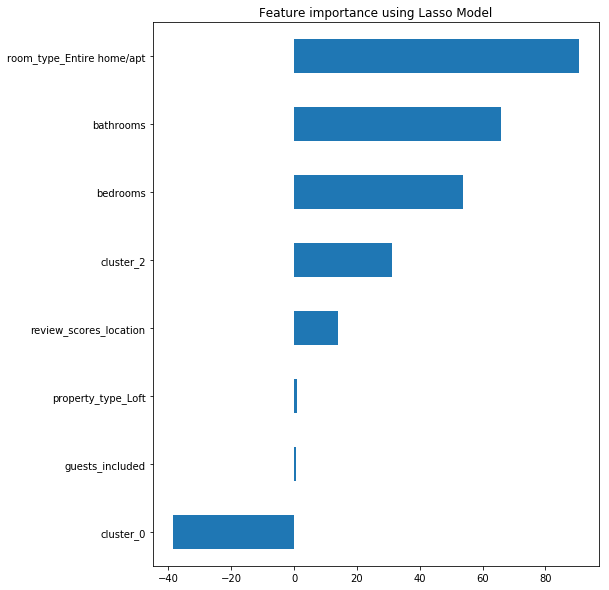

In [101]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

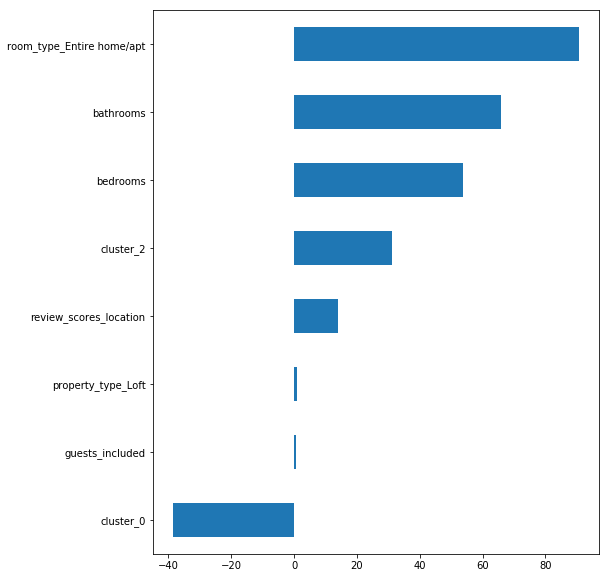

In [102]:
imp_coef.plot(kind = "barh")


Cluster 0 seems to be  poor or undesired neighbourhoods for rent, since it has a negative coefficients.

In [97]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster'] == 0].head()

neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0       Arlington, Staten Island       Automotive Shop              Bus Stop   
4           Bath Beach, Brooklyn       Automotive Shop                Office   
10             Bayswater, Queens              Building                Office   
11  Bedford-Stuyvesant, Brooklyn         Deli / Bodega    Salon / Barbershop   
13                Belmont, Bronx    Italian Restaurant    Salon / Barbershop   

                       3rd Most Common Venue  \
0                                     Church   
4                                       Food   
10                             Deli / Bodega   
11  Residential Building (Apartment / Condo)   
13                                    Bakery   

                       4th Most Common Venue 5th Most Common Venue  \
0                             Hardware Store              Building   
4                                     Church            Nail Salon   
10                           Automotive Shop    Salon / Barbershop   
11                                    Church                Office   
13  Residential Building (Apartment / Condo)       Doctor's Office   

   6th Most Common Venue 7th Most Common Venue       8th Most Common Venue  \
0     Salon / Barbershop         Deli / Bodega             Laundry Service   
4     Salon / Barbershop    Chinese Restaurant           Convenience Store   
10    Chinese Restaurant                Church  Financial or Legal Service   
11              Building     Fish & Chips Shop                         Bar   
13         Deli / Bodega           Pizza Place                       Diner   

    cluster  
0         0  
4         0  
10        0  
11        0  
13        0

Cluster 2 seems to be a cluster of affluent neighbourhoods.

In [103]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster'] == 2].head(5)

neighbourhood 1st Most Common Venue  \
5    Battery Park City, Manhattan                Office   
16      Bloomfield, Staten Island                Office   
54                DUMBO, Brooklyn                Office   
57    Downtown Brooklyn, Brooklyn                Office   
72  Financial District, Manhattan                Office   

                       2nd Most Common Venue 3rd Most Common Venue  \
5   Residential Building (Apartment / Condo)              Building   
16                           Doctor's Office              Building   
54                               Art Gallery          Tech Startup   
57                               College Lab     College Classroom   
72                                  Building            Food Truck   

     4th Most Common Venue            5th Most Common Venue  \
5                     Park                       Food Truck   
16                   Hotel     General College & University   
54      Advertising Agency                         Building   
57                Building  College Administrative Building   
72  College Residence Hall                      Coffee Shop   

                       6th Most Common Venue  \
5                         Salon / Barbershop   
16                              Neighborhood   
54  Residential Building (Apartment / Condo)   
57                       Government Building   
72                             Deli / Bodega   

                       7th Most Common Venue        8th Most Common Venue  \
5                        Monument / Landmark                         Bank   
16                           Business Center                       Lawyer   
54                            Scenic Lookout                          Gym   
57                                Public Art  College Technology Building   
72  Residential Building (Apartment / Condo)          Government Building   

    cluster  
5         2  
16        2  
54        2  
57        2  
72        2

### Conclusion

While the model achieved not bad results, the results are not really suitable for deployment as a reliable service for tourists.  

To improve it we need more details in the data, a better clustering algorithms.



### Further

The Clustering Algorithms needs a better similarity metric to compare similar venues, for example, the distance between different types of restaurants is the same as between a restaurant and an office.